In [1]:
# General
import os
import sys
import shutil
import posixpath
import warnings
import importlib
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# SciPy
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.signal import periodogram, butter, filtfilt

# Gpflow & tensorflow
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import gpflow
f64 = gpflow.utilities.to_default_float
from gpflow.kernels import *

# Files
import csv
import pandas as pd
import seaborn as sns
import wfdb
from scipy.io import loadmat  

# Local scripts
#sys.path.insert(0, '/home/david/Documenten/Courses/Spectral Discontinuity Design/Thesis AI/Implementation/')
sys.path.insert(0, os.chdir(".."))
from SpectralMixture import SpectralMixture, initialize_from_emp_spec
import toolbox as t
from bnqdflow import models, base, effect_size_measures, util, analyses
sns.set(style='whitegrid')

### Load data

In [2]:
def load_data(record):
    x1, x2 = [], []
    y1, y2 = [], []

    # Pre meditation 
    with open('datasets/heart-rate-oscillations-during-meditation-1.0.0/data/'+record[1], 'r') as file:
        for line in file:
            x, y = line.strip().split()
            x, y = np.float32(x), np.float32(y) 
            x1.append(x)
            y1.append(y)
    x1 = np.array(x1)
    y1 = np.array(y1)

    # During medition
    with open('datasets/heart-rate-oscillations-during-meditation-1.0.0/data/'+record[0], 'r') as file:
        for line in file:
            x, y = line.strip().split()
            x, y = np.float32(x), np.float32(y) 
            x2.append(x)
            y2.append(y)
    x2 = np.array(x2)
    y2 = np.array(y2)
    
    # Combined time series
    δ   = x2[0]- x1[-1]
    x2 -= δ
    X   = np.append(x1, x2)
    Y   = np.append(y1, y2)
    b   = x1[-1]
    
    return X, Y, b

def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed

    
def plot_data(X, Y, b, y_lim=(40,150), title='Combined meditation data'):
    fig = plt.figure(figsize=(15,6))
    plt.plot(X, Y, label='meditation chi',color='k')
    plt.axvline(b, color='k', linestyle='--')
    plt.title(title)
    plt.legend(loc='best')
    #plt.ylim(y_lim[0],y_lim[1])
    plt.show()

(2021,) 8083


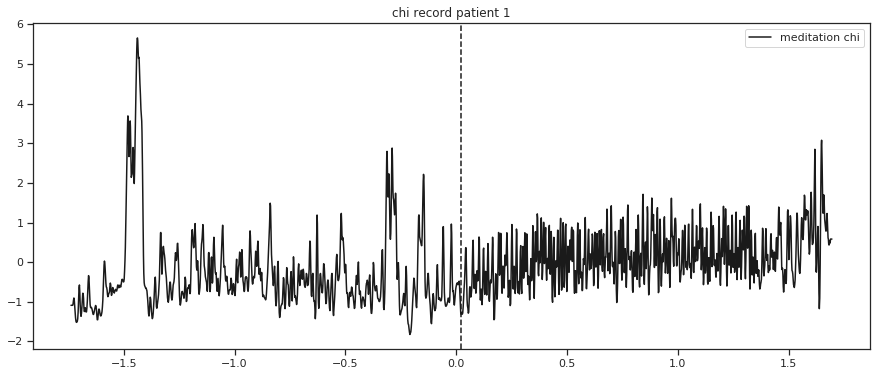

(2274,) 9094


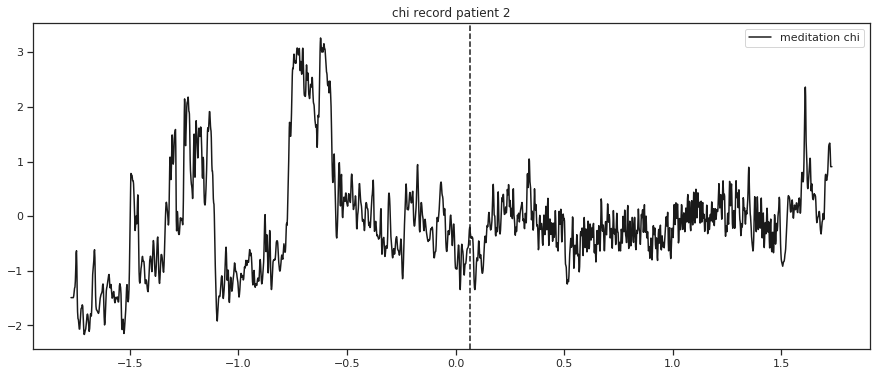

(2129,) 8515


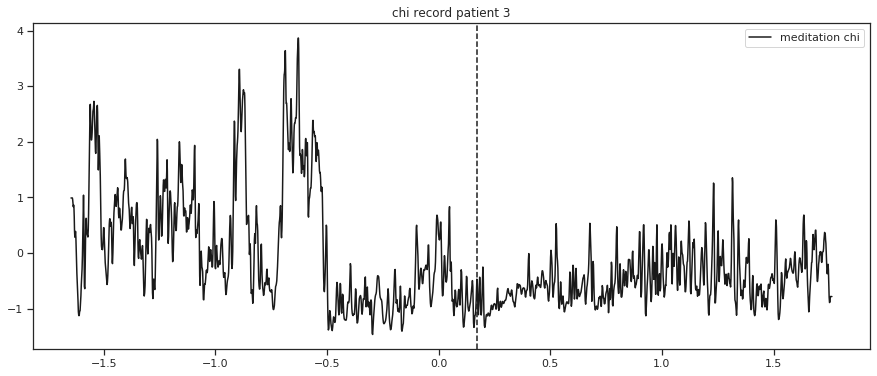

(2114,) 8456


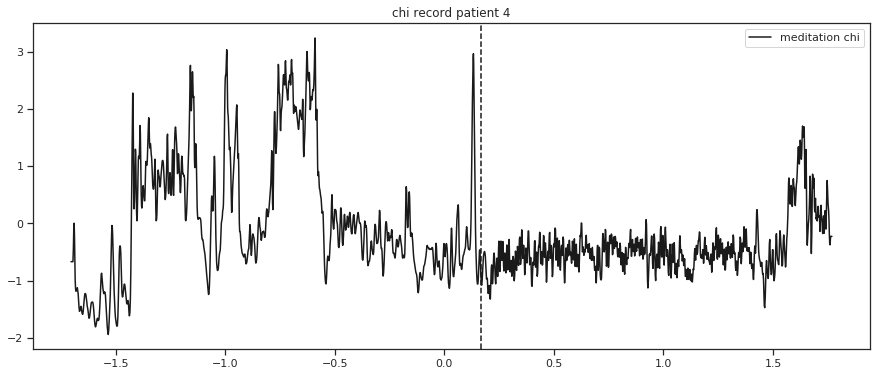

(2090,) 8359


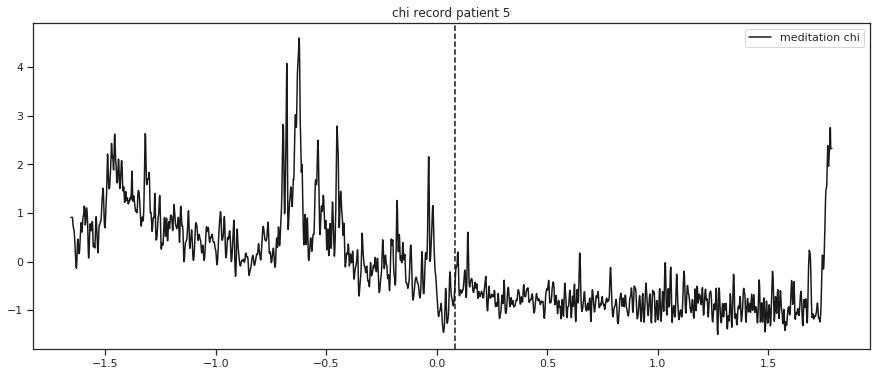

(2104,) 8413


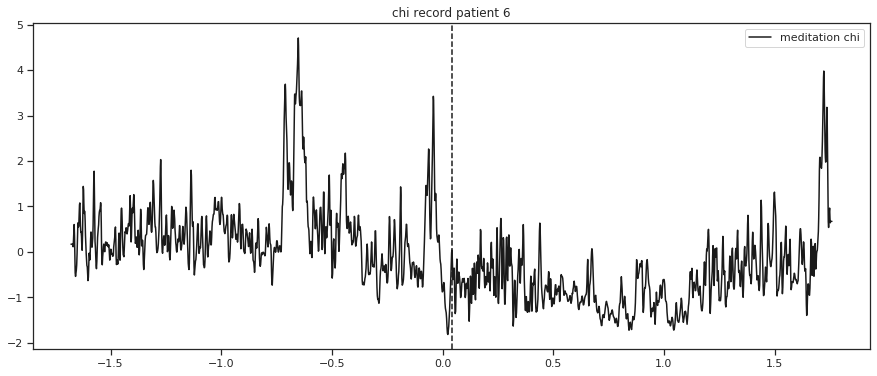

(2831,) 11324


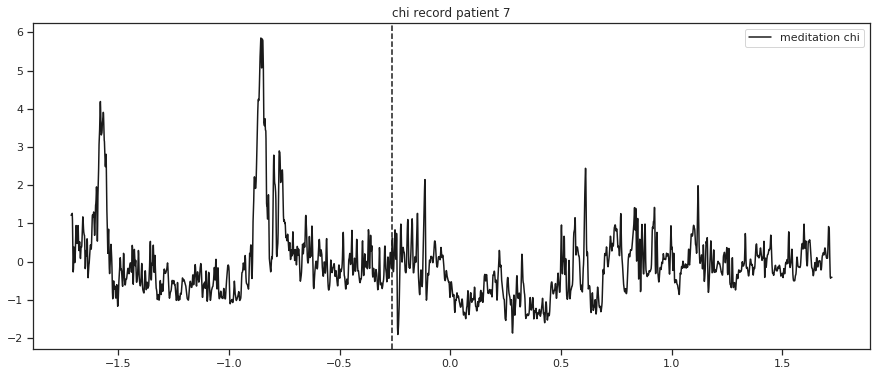

(2543,) 10171


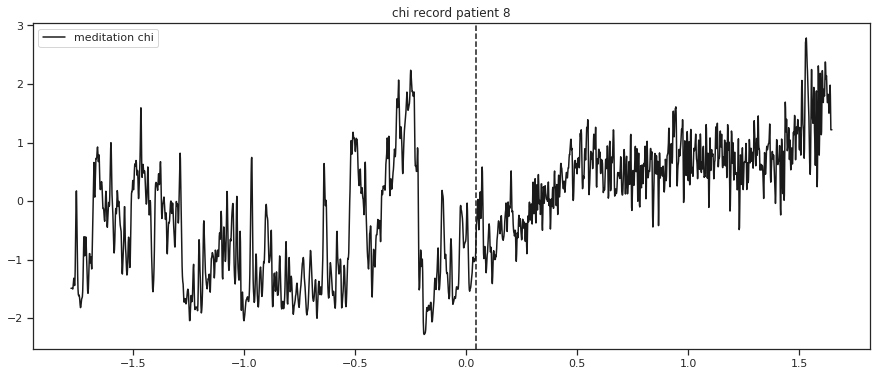

(396,) 1584


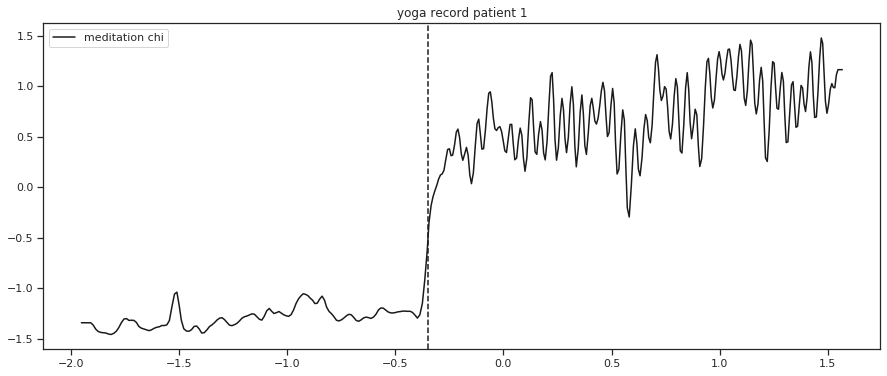

(465,) 1860


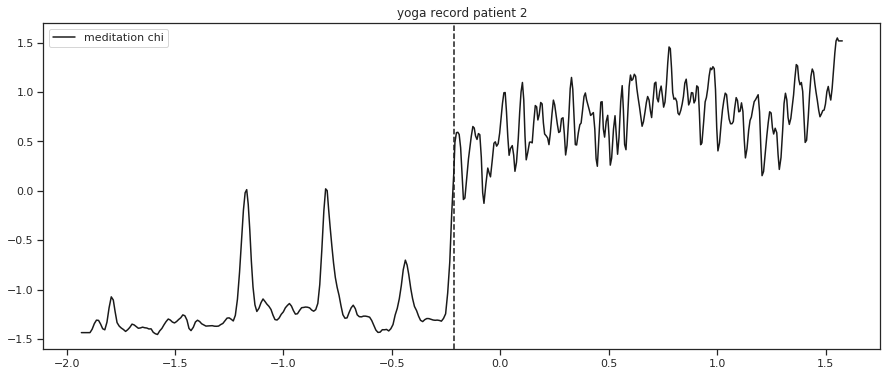

(408,) 1630


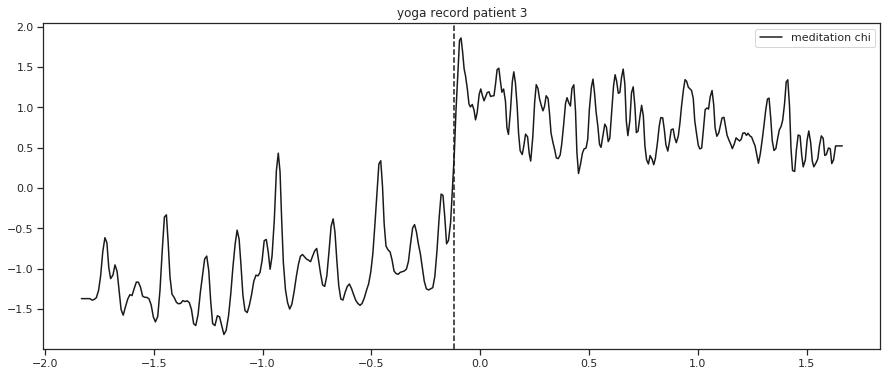

(346,) 1384


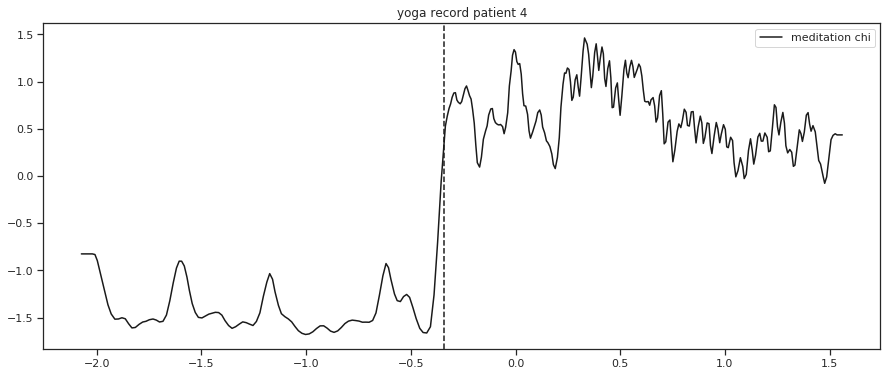

In [18]:
folders = ['chi', 'yoga']
X = []
degree = 12

for folder in folders:    
    # Read records of a given dataset
    X_f = [] # All data of a folder
    records = []
    with open('datasets/heart-rate-oscillations-during-meditation-1.0.0/data/'+folder+'/RECORDS', 'r') as file:
        for line in file:
            name = line.strip()
            name = folder+'/'+name[:2]+'.'+name[2:]
            records.append(name)
    records = np.array(records)
    records = records.reshape(int(records.shape[0]/2),2) # (n_patients, 2)
    
    # Read in data set
    X_i = [] # Dataset of a patient
    for i, patient in enumerate(records):
        X_i, Y_i, b_i = load_data(records[i])
        
        # Apply triangular smoothing window
        Y_i = np.array(smoothTriangle(Y_i, degree))
        n=Y_i.shape[0]
        step_down = 4
        Y_i = Y_i[np.arange(int(n))%step_down==0]
        X_i = X_i[np.arange(int(n))%step_down==0]
        print(Y_i.shape,n)

        # Standardize data
        zscorey = lambda y: (y - np.mean(Y_i)) / np.std(Y_i)
        zscorex = lambda x: (x - np.mean(X_i)) / np.std(X_i)
        μ_xi, σ_xi = np.mean(X_i), np.std(X_i)
        μ_yi, σ_yi = np.mean(Y_i), np.std(Y_i)
        norm = [μ_xi, μ_yi, σ_xi, σ_yi]
        b_i = zscorex(b_i)
        Y_i = zscorey(Y_i)
        X_i = zscorex(X_i)
        
        plot_data(X_i, Y_i, b_i, title=f'{folder} record patient {i+1}')
        X_f.append(np.array([X_i,Y_i,b_i, norm]))

    X_f = np.array(X_f) 
    X.append(X_f)
X = np.array(X)

## Periodogram for comparison


Patient 1


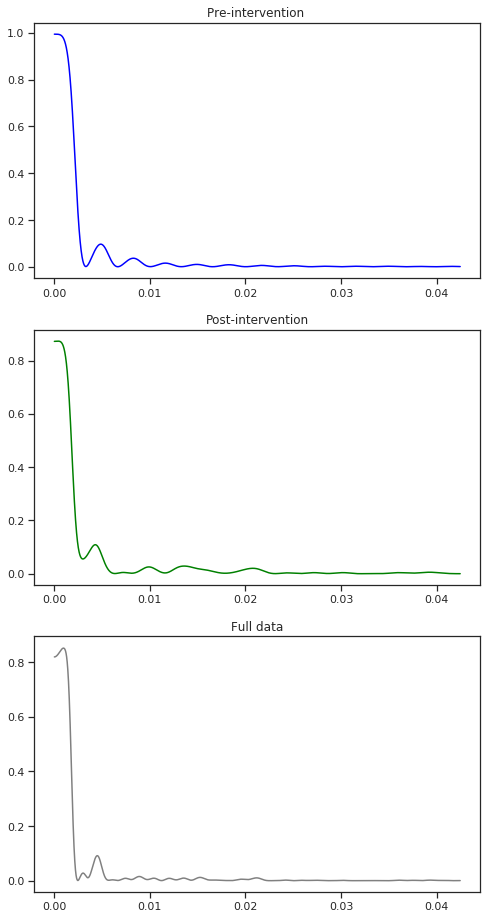

Patient 2


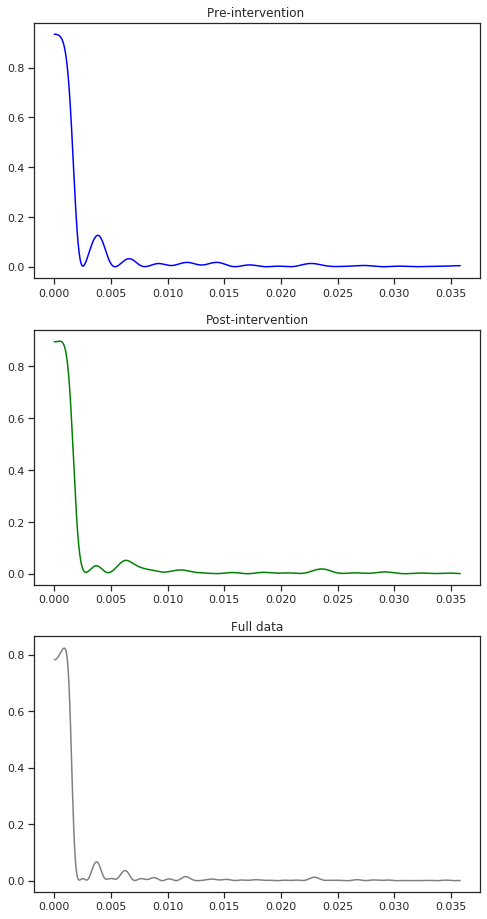

Patient 3


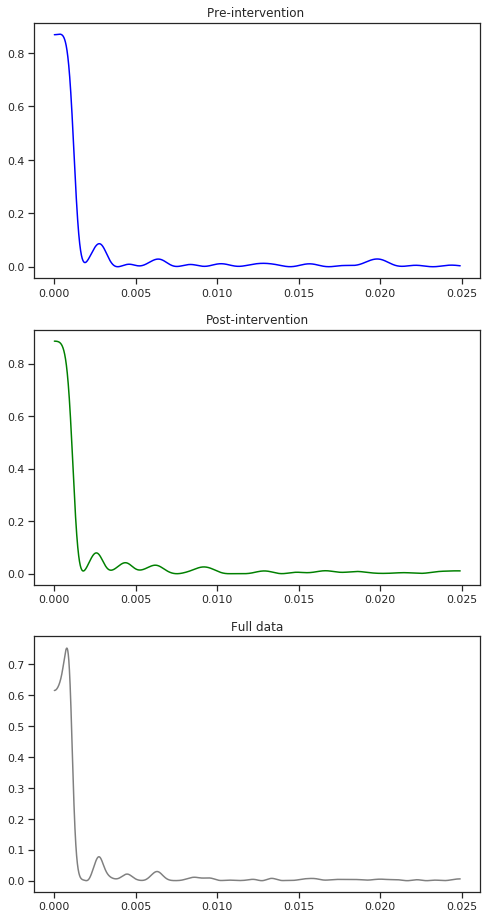

Patient 4


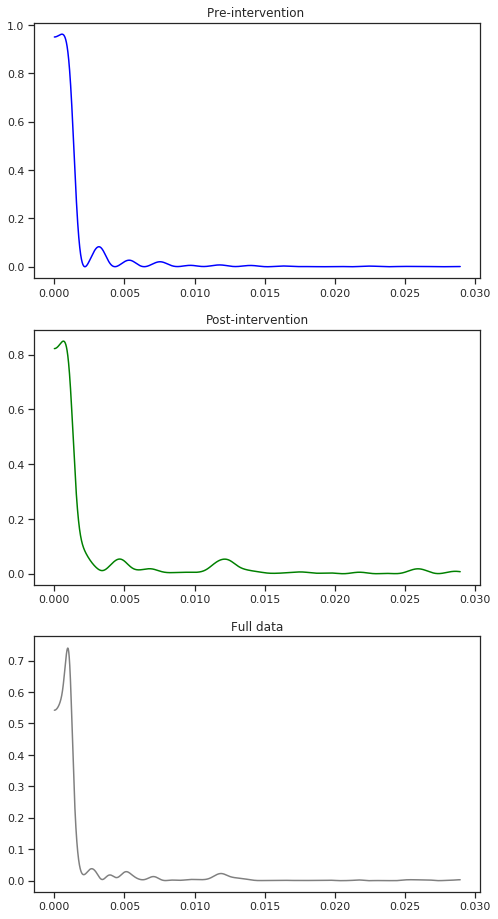

In [13]:
import scipy.signal as signal
for p, patient in enumerate(X[1]):
    X_i, Y_i, b_i,norm = patient
    μ_xi, μ_yi, σ_xi, σ_yi = norm 
    x1, x2 = np.float64(X_i[X_i<=b_i]), np.float64(X_i[X_i>b_i])
    y1, y2 = np.float64(Y_i[:len(x1)]), np.float64(Y_i[len(x1):])
    fig, ax = plt.subplots(3,1, figsize=(8,16))
    freqs = np.linspace(0.01, 50, 10000)
    print(f'Patient {p+1}')
    # Plot periodogram
    Pxx = signal.lombscargle(x1, y1, freqs, normalize=True)
    ax[0].plot(freqs/μ_xi, Pxx, color='blue')
    ax[0].set_title('Pre-intervention ')
    Pxx = signal.lombscargle(x2, y2, freqs, normalize=True)
    ax[1].plot(freqs/μ_xi, Pxx, color='green')
    #ax[1].set_ylim((0,0.2))
    ax[1].set_title('Post-intervention')
    Pxx = signal.lombscargle(X_i, Y_i, freqs, normalize=True)
    ax[2].plot(freqs/μ_xi, Pxx,color='grey')
    ax[2].set_title('Full data')
    plt.show()

(181,) (227,) (181,) (227,) (408,) (408,)
380.8823
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
╒════════════════════════════════════════════════════════════╤═══════════╤════════════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════╕
│ name                                                       │ class     │ transform              │ prior   │ trainable   │ shape   │ dtype   │          value │
╞════════════════════

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
╒═══════════════════════════════════════════════════════════════╤═══════════╤════════════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════╕
│ name                                                          │ class     │ transform              │ prior   │ trainable   │ shape   │ dtype   │         value │
╞═══════════════════════════════════════════════════════════════╪═══════════╪════════════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════╡
│ DiscontinuousModel.models[0].kernel.kernels[0].mixture_weight │ Parameter │ Sigmoid + AffineScalar │         │ True        │ ()      │ float64 │   0.000788509 │
├────────────────────────────────────────────

L: 304.6276300988974, k: 32, N: 408
BIC: 208.44735530843082
Bayes factor Md-Mc: -428.63950311310174
10 tf.Tensor(-428.63950311310174, shape=(), dtype=float64)
test
Trained value lengthscale  2.4038524520956908
Scaled value 0.07944352603463795
final variance:  12.587558104659061
Trained value lengthscale  16.001867006508004
Scaled value 0.2049698278655817
final variance:  4.878766842970642
Trained value lengthscale  11.893673066270585
Scaled value 0.1767106019611031
final variance:  5.658970027277234
Trained value lengthscale  10.498342480857584
Scaled value 0.1660217457650192
final variance:  6.023307340806797
Trained value lengthscale  0.10845904692906252
Scaled value 0.016874755926471967
final variance:  59.26011637485483
Trained value lengthscale  11.87240439102326
Scaled value 0.17655253127452308
final variance:  5.664036605881856
Trained value lengthscale  11.811493504745942
Scaled value 0.17609905110745086
final variance:  5.678622307793284
Trained value lengthscale  11.665647576

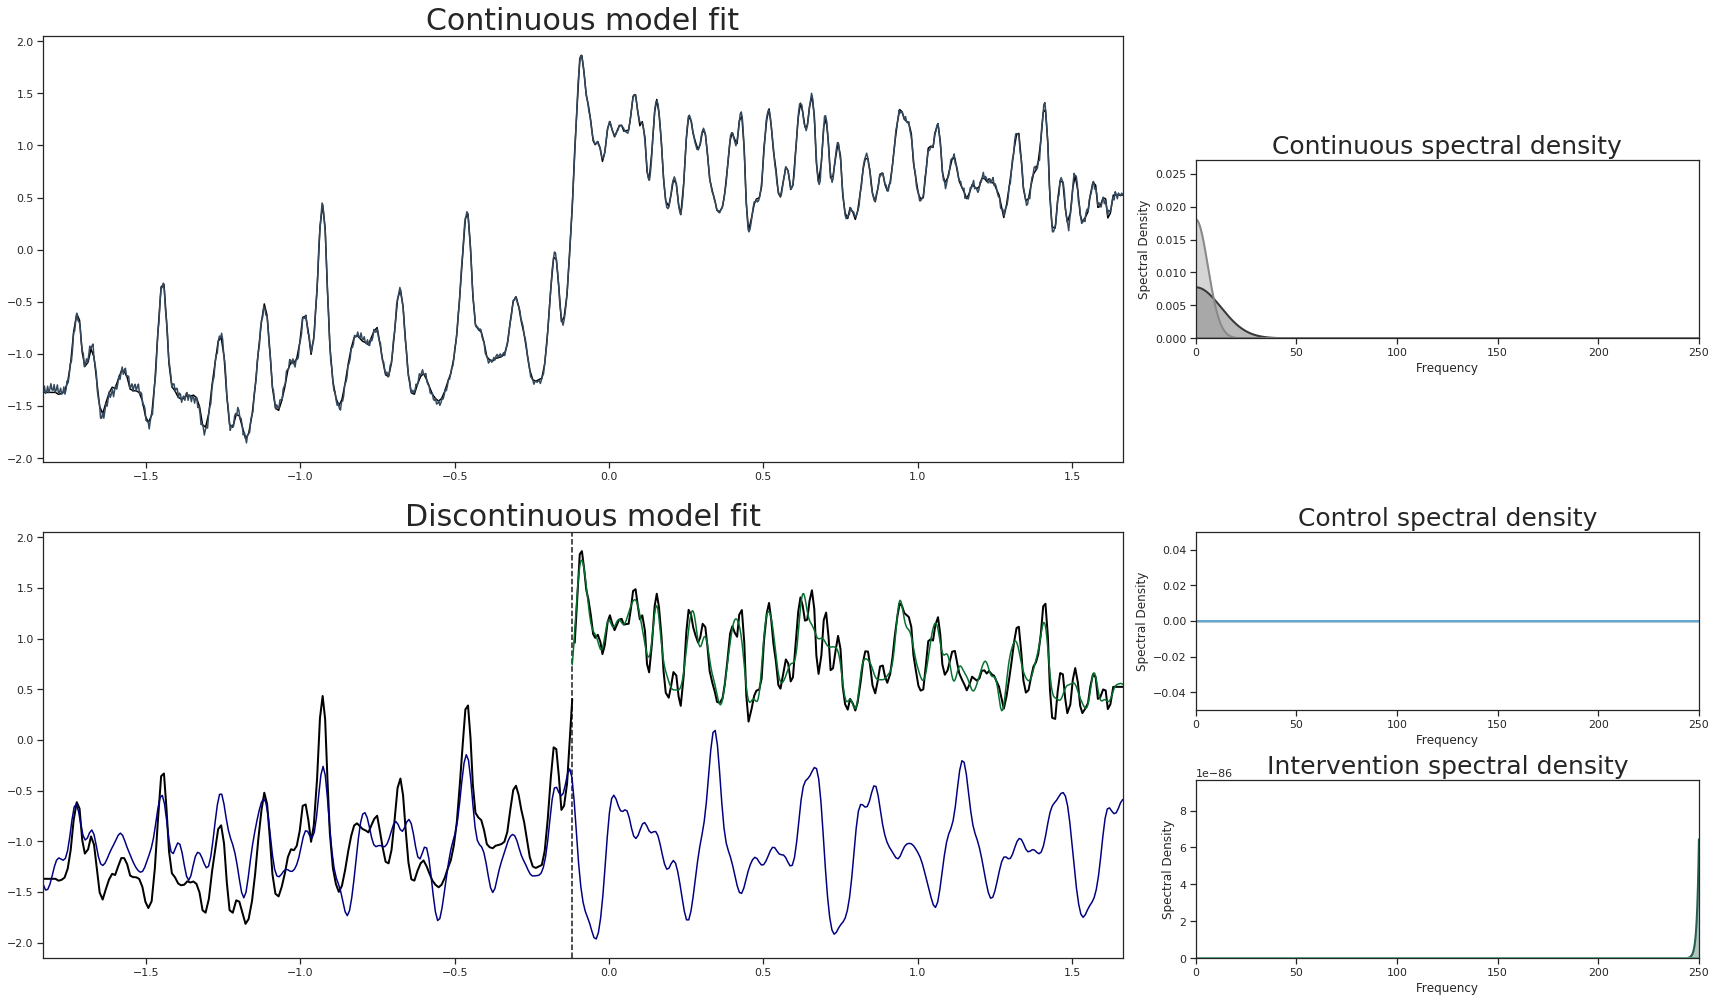

In [27]:
## Run SM analyses
# yoga patients
for p, patient in enumerate(X[1]):
    if p is not 2:
        continue
    X_i, Y_i, b_i, norm = patient
    μ_xi, μ_yi, σ_xi, σ_yi = norm 
    x1, x2 = c, np.float64(X_i[X_i>b_i])
    y1, y2 = np.float64(Y_i[:len(x1)]), np.float64(Y_i[len(x1):])
    print(x1.shape, x2.shape,y1.shape,y2.shape,X_i.shape,Y_i.shape)
    print(σ_xi)

    max_length      = 20.
    max_freq        = 200.  
    #Q               = 2 #t.find_optimal_Q(X_i, Y_i, min_Q=1, max_Q=4, max_length=max_length, max_freq=max_freq, plot_BIC_scores=True)
    for i in range(10,11):
        Q = i
        sm              = SpectralMixture(Q, max_length=max_length, max_freq=max_freq) 
        sm              = sm + Constant() 

        a               = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], sm, b_i, share_params=False)
        a.train(verbose=True)
        log_bayes_factor = a.log_bayes_factor(verbose=True)
        print(i, log_bayes_factor)
        t.plot_posterior_model_spectrum(a, Q, padding=0, max_x = 250,lineplot=True, scalar = σ_xi)
        plt.show()

In [20]:
# t.plot_posterior_model_spectrum(a, Q, padding=0, max_x = 45,lineplot=False, scalar = σ_xi)
# plt.show()

In [ ]:
## Run SM analyses
# yoga patients
for p, patient in enumerate(X[0]):
    if p is not 0:
        continue
    X_i, Y_i, b_i, norm = patient
    μ_xi, μ_yi, σ_xi, σ_yi = norm 
    x1, x2 = np.float64(X_i[X_i<=b_i]), np.float64(X_i[X_i>b_i])
    y1, y2 = np.float64(Y_i[:len(x1)]), np.float64(Y_i[len(x1):])
    print(x1.shape, x2.shape,y1.shape,y2.shape,X_i.shape,Y_i.shape)
    print(σ_xi)

    max_length      = 1.
    max_freq        = 50.  
    #Q               = 2 #t.find_optimal_Q(X_i, Y_i, min_Q=1, max_Q=4, max_length=max_length, max_freq=max_freq, plot_BIC_scores=True)
    for i in range(1,4):
        Q = i
        sm              = SpectralMixture(Q, max_length=max_length, max_freq=max_freq) 
        sm              = sm + Constant() 

        a               = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], sm, b_i, share_params=False)
        a.train(verbose=True)
        log_bayes_factor = a.log_bayes_factor(verbose=True)
        print(i, log_bayes_factor)
        t.plot_posterior_model_spectrum(a, Q, padding=0, max_x = 0.2,lineplot=True, scalar = σ_xi)
        plt.show()